In [1]:
class EchoStateNetworkMulti:
    def __init__(self, n_inputs, n_outputs,
                 n_res_fast=200, n_res_slow=200,
                 sr_fast=0.95, sr_slow=0.75,
                 leak_fast=0.30, leak_slow=0.15,
                 sparsity=0.90, input_scaling=1.0,
                 use_bias_in=True,
                 ext_bias_fast=0.0, ext_bias_slow=0.0,
                 add_input_to_readout=True,
                 ridge_alpha=1e-2,
                 noise=0.0, random_state=42, washout=0,
                 input_bias=None):

        self.n_inputs, self.n_outputs = n_inputs, n_outputs
        self.nf, self.ns = n_res_fast, n_res_slow
        self.sr_fast, self.sr_slow = sr_fast, sr_slow
        self.leak_f, self.leak_s = leak_fast, leak_slow
        self.sparsity, self.input_scaling = sparsity, input_scaling
        self.use_bias_in = use_bias_in
        self.ext_bias_f, self.ext_bias_s = float(ext_bias_fast), float(ext_bias_slow)
        self.add_input_to_readout = add_input_to_readout
        
        self.ridge_alpha = ridge_alpha
        self.washout = washout

        self.noise = noise
        self.rng = np.random.RandomState(random_state)

        if input_bias is not None:
            input_bias = np.asarray(input_bias, dtype=float)
            assert input_bias.shape == (n_inputs,)
        self.input_bias = input_bias

        self._init_weights()
        self.readout = Ridge(alpha=self.ridge_alpha, fit_intercept=False)

    def _init_weights(self):
        def init_block(n_res, sr):
            in_dim = self.n_inputs + (1 if self.use_bias_in else 0)
            Win = (self.rng.rand(n_res, in_dim) - 0.5) * 2.0 * self.input_scaling
            W = self.rng.rand(n_res, n_res) - 0.5
            W[self.rng.rand(n_res, n_res) < self.sparsity] = 0.0
            eigmax = np.max(np.abs(np.linalg.eigvals(W))) or 1e-6
            return Win, (W / eigmax) * sr
        self.Win_f, self.W_f = init_block(self.nf, self.sr_fast)
        self.Win_s, self.W_s = init_block(self.ns, self.sr_slow)

    def _run(self, X):
        T = X.shape[0]
        xf, xs = np.zeros(self.nf), np.zeros(self.ns)
        states = np.zeros((T, self.nf + self.ns))

        for t in range(T):
            u = X[t]
            if self.input_bias is not None:
                u = u + self.input_bias

            u_in = np.append(u, 1.0) if self.use_bias_in else u

            xf = (1 - self.leak_f) * xf + self.leak_f * np.tanh(self.Win_f @ u_in + self.W_f @ xf) + self.ext_bias_f
            xs = (1 - self.leak_s) * xs + self.leak_s * np.tanh(self.Win_s @ u_in + self.W_s @ xs) + self.ext_bias_s

            if self.noise:
                xf += self.noise * self.rng.randn(*xf.shape)
                xs += self.noise * self.rng.randn(*xs.shape)

            states[t] = np.concatenate([xf, xs])

        return states

    def fit(self, X, Y):
        S = self._run(X)
        ws = self.washout
        feats = [S[ws:]]
        if self.add_input_to_readout:
            feats.append(X[ws:])
        feats.append(np.ones((len(X) - ws, 1)))
        Phi = np.hstack(feats)
        self.readout.fit(Phi, Y[ws:])

    def predict(self, X):
        S = self._run(X)
        feats = [S]
        if self.add_input_to_readout:
            feats.append(X)
        feats.append(np.ones((len(X), 1)))
        Phi = np.hstack(feats)
        return self.readout.predict(Phi)

In [2]:
from random import random
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import pickle
import cvxpy as cp
import os, json, joblib
import tensorflow as tf
import random as rnd
import cvxpy as cp

plt.style.use("seaborn-v0_8")

np.random.seed(42)
rnd.seed(42)
tf.random.set_seed(42)

In [3]:
def max_drawdown(series: pd.Series):
    roll_max = series.cummax()
    dd = series / roll_max - 1.0
    return dd.min(), dd

In [4]:
file_path = r"E:\models\ESN_Model2_ALIGNED\ESN_Model2_full.pkl"

with open(file_path, "rb") as f:
    data = pickle.load(f)

model     = data["model"]
scX       = data["scX"]
scY       = data["scY"]
assets    = data["assets"]
LAGS      = int(data["LAGS"])
SEQ       = int(data["SEQ"])
X_columns = data["X_columns"]

print("\n✓ Model 2 bundle loaded")
print(f"Assets        : {len(assets)}")
print(f"LAGS          : {LAGS}")
print(f"SEQ           : {SEQ}")
print(f"# Features    : {len(X_columns)}")
print(f"Reservoir dim : {model.nf + model.ns}")

df = pd.read_csv(r"E:\data\stock_prices.csv",index_col="date",parse_dates=True).sort_index()

print("Price data shape:", df.shape)

px_monthly  = df.resample("ME").last()
retm_assets = px_monthly.pct_change().dropna()

print("Monthly returns shape:", retm_assets.shape)


✓ Model 2 bundle loaded
Assets        : 10
LAGS          : 11
SEQ           : 5
# Features    : 193
Reservoir dim : 90
Price data shape: (1950, 10)
Monthly returns shape: (93, 10)


In [5]:
# ============================================================
# 3. FEATURE PIPELINE (same as training)
# ============================================================
def compute_returns(px_df, kind="log"):
    return (np.log(px_df).diff() if kind == "log" else px_df.pct_change()).dropna()

def realized_vol(ret_df, window=20):
    return ret_df.rolling(window, min_periods=window).std()

def add_time_lags_df(df_in, lags=5, name_suffix=""):
    parts = [df_in.shift(k).add_suffix(f"{name_suffix}_t-{k}") for k in range(1, lags + 1)]
    return pd.concat(parts, axis=1)

def build_features_target_next_price(px_df, lags=5, vol_windows=(5, 20), include_level=True):
    ret = compute_returns(px_df, "log")
    px_aligned = px_df.loc[ret.index]

    X_ret = add_time_lags_df(ret, lags=lags, name_suffix="_r")
    X_vol = pd.concat([
        add_time_lags_df(realized_vol(ret, w), lags=min(3, lags), name_suffix=f"_vol{w}")
        for w in vol_windows
    ], axis=1)

    mkt_vol = realized_vol(ret, window=vol_windows[0]).median(axis=1)
    q = mkt_vol.quantile([0.33, 0.66])

    X_reg = pd.concat([
        (mkt_vol <= q.iloc[0]).astype(int).rename("reg_low"),
        ((mkt_vol > q.iloc[0]) & (mkt_vol <= q.iloc[1])).astype(int).rename("reg_mid"),
        (mkt_vol > q.iloc[1]).astype(int).rename("reg_high")
    ], axis=1)

    parts = [X_ret, X_vol, X_reg]

    if include_level:
        X_lvl = add_time_lags_df(px_aligned - px_aligned.mean(), lags=min(2, lags), name_suffix="_lvl")
        parts.append(X_lvl)

    X = pd.concat(parts, axis=1).dropna()
    Y = px_aligned.shift(-1).reindex(X.index).dropna()
    X = X.loc[Y.index]

    return X, Y

In [6]:
SEQ = int(data["SEQ"])  

# 1) rebuild + scale (same as before)
X_full_df, Y_full_df = build_features_target_next_price(df, lags=LAGS)
X_full_df = X_full_df[X_columns]
X_full_sc = scX.transform(X_full_df)

print("Full feature matrix:", X_full_df.shape)

# 2) run reservoir ONCE on full stream (stateful)
S_full = model._run(X_full_sc)                  # (T, res_dim)

# 3) build readout features for each window end (t = SEQ-1 ... T-2)
S_last = S_full[SEQ-1:-1]                       # states at window end
X_last = X_full_sc[SEQ-1:-1]                    # last input of window

Phi_parts = [S_last]
if model.add_input_to_readout:
    Phi_parts.append(X_last)
Phi_parts.append(np.ones((S_last.shape[0], 1))) # bias

Phi = np.hstack(Phi_parts)                      # (T-SEQ, F)

# 4) predict (scaled) + inverse-scale
Y_hat_sc = model.readout.predict(Phi)           # (T-SEQ, n_assets)
Y_hat = scY.inverse_transform(Y_hat_sc)

# 5) align dates & prices
idx_real = X_full_df.index[SEQ:]                # corresponds to Y at t+1

P_t      = df[assets].loc[idx_real].values
P_1_real = df[assets].shift(-1).loc[idx_real].values

# 6) H+1 returns
r_hat  = (Y_hat - P_t) / P_t
r_real = (P_1_real - P_t) / P_t

r_hat_df  = pd.DataFrame(r_hat,  index=idx_real, columns=assets)
r_real_df = pd.DataFrame(r_real, index=idx_real, columns=assets)

common_idx = r_hat_df.dropna().index.intersection(r_real_df.dropna().index)
r_hat_df  = r_hat_df.loc[common_idx]
r_real_df = r_real_df.loc[common_idx]

print("r_hat_df shape:",  r_hat_df.shape)
print("r_real_df shape:", r_real_df.shape)

# 7) historical daily returns (for Σ)
rets_all = df[assets].pct_change().dropna()
print("rets_all shape:", rets_all.shape)

Full feature matrix: (1926, 193)
r_hat_df shape: (1921, 10)
r_real_df shape: (1921, 10)
rets_all shape: (1949, 10)


In [7]:
# ======================================================
# PSD FIX
# ======================================================
def make_psd(S, eps=1e-8):
    S = 0.5 * (S + S.T)
    w, V = np.linalg.eigh(S)
    w = np.maximum(w, eps)
    return (V * w) @ V.T


# ======================================================
# MARKOWITZ MIN-VAR
# ======================================================
def markowitz_minvar(mu, Sigma, allow_short, target_return=None, w_bounds=None):

    Sigma = make_psd(Sigma)

    n = len(mu)
    w = cp.Variable(n)

    cons = [cp.sum(w) == 1]

    # --- short-selling / bounds ---
    if allow_short:
        if w_bounds is not None:
            cons.append(w >= w_bounds[0])
            cons.append(w <= w_bounds[1])
    else:
        cons.append(w >= 0)

    # --- return constraint ---
    if target_return is not None:
        cons.append(mu @ w >= target_return)

    prob = cp.Problem(cp.Minimize(cp.quad_form(w, Sigma)), cons)
    prob.solve(solver=cp.SCS)

    if w.value is None:
        return np.ones(n) / n

    return np.array(w.value).ravel()


# ======================================================
# ROLLING ESN → MARKOWITZ (H+1)
# ======================================================
def rolling_esn_markowitz_H1(
    r_hat_df,
    r_real_df,
    rets_all,
    assets,
    lookback=252,
    allow_short=True,
    use_return_constraint=True,
    w_bounds=None
):

    records = []

    for t in r_hat_df.index:

        hist = rets_all.loc[:t].iloc[:-1].tail(lookback)
        if hist.shape[0] < lookback:
            continue

        if t not in r_real_df.index:
            continue

        mu_vec = r_hat_df.loc[t].values.astype(float)
        Sigma  = hist.cov(ddof=0).values

        if np.any(np.isnan(mu_vec)) or np.any(np.isnan(Sigma)):
            continue

        target_ret = float(mu_vec.mean()) if use_return_constraint else None

        # --- optimization ---
        w_star = markowitz_minvar(
            mu_vec,
            Sigma,
            allow_short=allow_short,
            target_return=target_ret,
            w_bounds=w_bounds
        )

        # --- realized return ---
        r_real = r_real_df.loc[t].values.astype(float)
        port_ret = float(np.dot(w_star, r_real))

        vol_daily  = float(np.sqrt(w_star @ Sigma @ w_star))
        vol_annual = vol_daily * np.sqrt(252)

        records.append({
            "date": t,
            "ret_real": port_ret,
            "vol_annual": vol_annual,
            "weights": dict(zip(assets, w_star))
        })

    return pd.DataFrame(records).set_index("date")


# ======================================================
# RUN BACKTEST
# ======================================================
results_esn2 = rolling_esn_markowitz_H1(
    r_hat_df=r_hat_df,
    r_real_df=r_real_df,
    rets_all=rets_all,
    assets=assets,
    lookback=252,
    allow_short=True,
    use_return_constraint=True,
    w_bounds=(-0.2, 0.2)   # <- bounds ενεργά
)

print("Model 2 ESN H+1 → Markowitz:", results_esn2.shape)
results_esn2.head()

Model 2 ESN H+1 → Markowitz: (1696, 3)


,ret_real,vol_annual,weights
date,,,
2019-01-04,0.007493,0.144375,"{'VOO': 0.2000042610565093, 'MSFT': -0.0683677..."
2019-01-07,0.010401,0.145783,"{'VOO': 0.20000027219650432, 'MSFT': -0.074125..."
2019-01-08,-0.002333,0.145962,"{'VOO': 0.20000371890393712, 'MSFT': -0.068135..."
2019-01-09,0.002127,0.146324,"{'VOO': 0.20000647641319474, 'MSFT': -0.067809..."
2019-01-10,0.002229,0.146340,"{'VOO': 0.20000077888132115, 'MSFT': -0.067864..."


=== ESN Model 2 → Markowitz (Horizon) ===
Total return: 2.6773571011176625
Annualized vol: 0.16476613861007805
Sharpe: 1.2571215435394982
Sortino: 1.6138167887571513
Max Drawdown: -0.21667834369572414


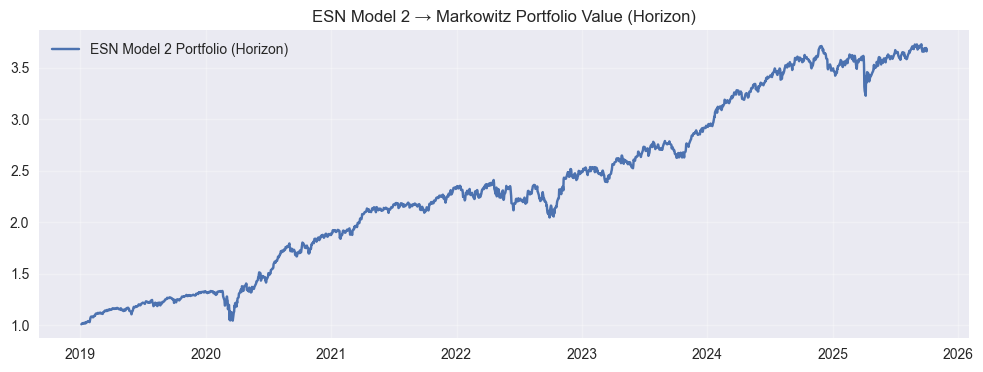

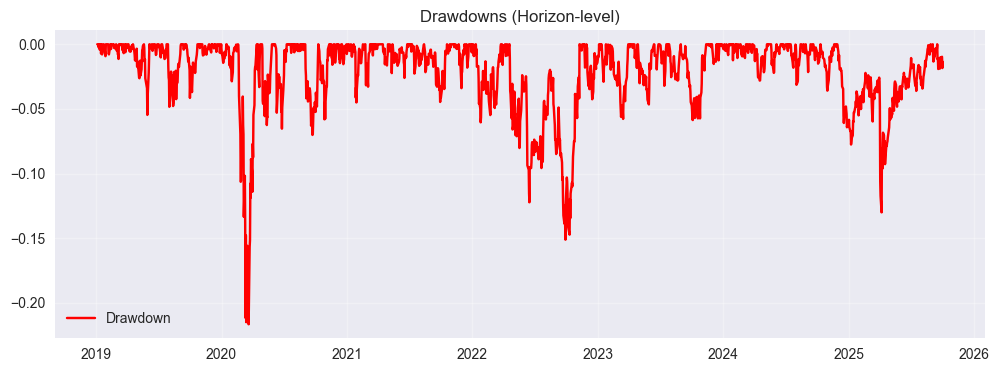

In [8]:
# ============================================================
# 5. HORIZON-LEVEL PORTFOLIO (MODEL 2)
# ============================================================

step_ret  = results_esn2["ret_real"].fillna(0.0)
portfolio = (1 + step_ret).cumprod()

def max_drawdown(series: pd.Series):
    roll_max = series.cummax()
    dd = series / roll_max - 1.0
    return dd.min(), dd

total_return = portfolio.iloc[-1] - 1.0
vol         = step_ret.std() * np.sqrt(252)
sharpe      = step_ret.mean() / step_ret.std() * np.sqrt(252)
sortino     = step_ret.mean() / step_ret[step_ret < 0].std() * np.sqrt(252)
mdd, dd     = max_drawdown(portfolio)

print("=== ESN Model 2 → Markowitz (Horizon) ===")
print("Total return:", total_return)
print("Annualized vol:", vol)
print("Sharpe:", sharpe)
print("Sortino:", sortino)
print("Max Drawdown:", mdd)

plt.figure(figsize=(12,4))
plt.plot(results_esn2.index, portfolio, label="ESN Model 2 Portfolio (Horizon)")
plt.grid(alpha=0.3)
plt.legend()
plt.title("ESN Model 2 → Markowitz Portfolio Value (Horizon)")
plt.show()

plt.figure(figsize=(12,4))
plt.plot(results_esn2.index, dd, color="red", label="Drawdown")
plt.grid(alpha=0.3)
plt.legend()
plt.title("Drawdowns (Horizon-level)")
plt.show()

In [9]:
# ============================================================
# 6. CONVERT ESN MODEL 2 TO MONTHLY
# ============================================================

portfolio_esn_daily   = portfolio.copy()
portfolio_esn_monthly = portfolio_esn_daily.resample("ME").last().dropna()
r_esn_monthly         = portfolio_esn_monthly.pct_change().dropna()

total_return_esn = portfolio_esn_monthly.iloc[-1] / portfolio_esn_monthly.iloc[0] - 1.0
vol_esn          = r_esn_monthly.std() * np.sqrt(12)
sharpe_esn       = r_esn_monthly.mean() / r_esn_monthly.std() * np.sqrt(12)
sortino_esn      = r_esn_monthly.mean() / r_esn_monthly[r_esn_monthly < 0].std() * np.sqrt(12)
mdd_esn, dd_esn  = max_drawdown(portfolio_esn_monthly)

print("=== ESN Model 2 (Monthly) ===")
print("Total return:", total_return_esn)
print("Annual vol:",   vol_esn)
print("Sharpe:",       sharpe_esn)
print("Sortino:",      sortino_esn)
print("Max DD:",       mdd_esn)
print("ESN M2 monthly start:", portfolio_esn_monthly.index[0])

=== ESN Model 2 (Monthly) ===
Total return: 2.422442188317107
Annual vol: 0.13965279116132695
Sharpe: 1.3823226172490002
Sortino: 3.2431849445122447
Max DD: -0.11292526548282267
ESN M2 monthly start: 2019-01-31 00:00:00


EW length: 87
IVOL length: 87
MVP length: 87


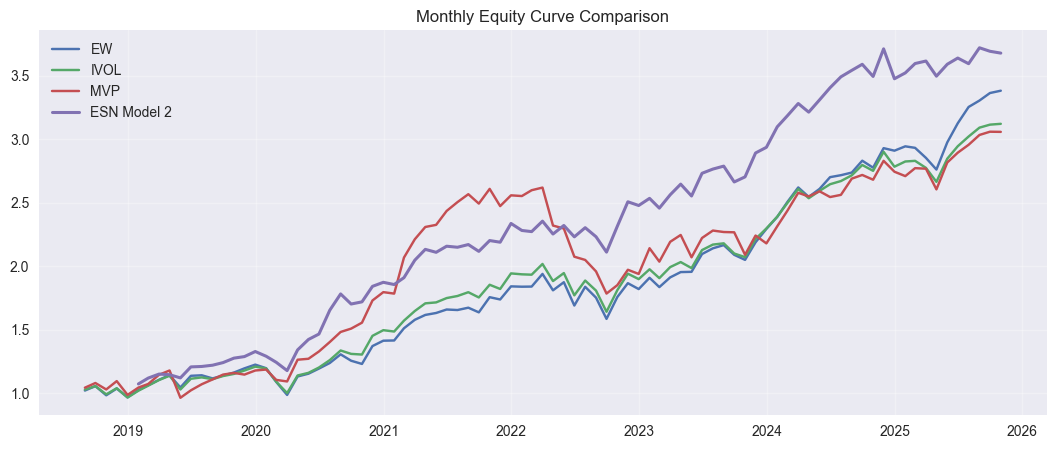

In [10]:
# ============================================================
# 7. CLASSIC STRATEGIES (EW / IVOL / MVP)
# ============================================================
def run_strategy(retm_assets: pd.DataFrame, method="EW", lookback=6):

    cols = retm_assets.columns
    eq = []
    weights_rec = []
    idx_list = []

    for t in range(lookback, len(retm_assets)):
        window = retm_assets.iloc[t-lookback:t]

        if method == "EW":
            w = np.ones(len(cols)) / len(cols)

        elif method == "IVOL":
            vol = window.std(ddof=0)
            inv = 1 / vol.replace(0, np.nan)
            w = (inv / inv.sum()).fillna(0.0).values

        elif method == "MVP":
            Sigma = make_psd(window.cov(ddof=0).values)
            n = len(cols)
            w_var = cp.Variable(n)
            prob = cp.Problem(cp.Minimize(cp.quad_form(w_var, Sigma)),
                              [cp.sum(w_var) == 1, w_var >= 0])
            prob.solve(solver=cp.SCS)
            w = np.array(w_var.value).ravel()

        r = retm_assets.iloc[t].values
        port_ret = float(r @ w)

        if len(eq) == 0:
            eq.append(1 * (1 + port_ret))
        else:
            eq.append(eq[-1] * (1 + port_ret))

        weights_rec.append(w)
        idx_list.append(retm_assets.index[t])

    eq = pd.Series(eq, index=idx_list)
    weights_df = pd.DataFrame(weights_rec, index=idx_list, columns=cols)
    return eq, weights_df


# RUN ALL 3 STRATEGIES
eq_EW,   w_EW   = run_strategy(retm_assets, "EW")
eq_IVOL, w_IVOL = run_strategy(retm_assets, "IVOL")
eq_MVP,  w_MVP  = run_strategy(retm_assets, "MVP")

print("EW length:", len(eq_EW))
print("IVOL length:", len(eq_IVOL))
print("MVP length:", len(eq_MVP))

# ============================================================
# 8. PLOT COMPARISON – ESN (monthly) vs EW / IVOL / MVP
# ============================================================
plt.figure(figsize=(13,5))
plt.plot(eq_EW,   label="EW")
plt.plot(eq_IVOL, label="IVOL")
plt.plot(eq_MVP,  label="MVP")
plt.plot(portfolio_esn_monthly, label="ESN Model 2", linewidth=2.2)

plt.grid(alpha=0.3)
plt.legend()
plt.title("Monthly Equity Curve Comparison")
plt.show()

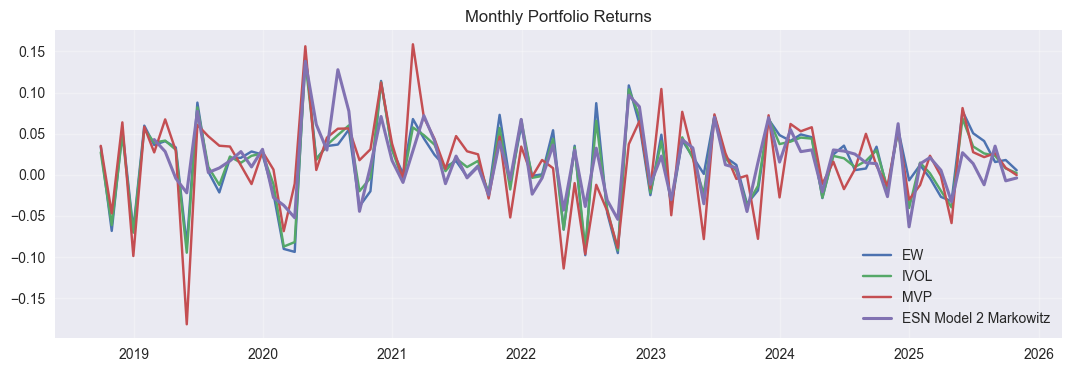

In [11]:
# ===============================
# MONTHLY RETURNS 
# ===============================
r_EW   = eq_EW.pct_change().dropna()
r_IVOL = eq_IVOL.pct_change().dropna()
r_MVP  = eq_MVP.pct_change().dropna()
r_ESN  = portfolio_esn_monthly.pct_change().dropna()

plt.figure(figsize=(13,4))
plt.plot(r_EW,   label="EW")
plt.plot(r_IVOL, label="IVOL")
plt.plot(r_MVP,  label="MVP")
plt.plot(r_ESN,  label="ESN Model 2 Markowitz", linewidth=2.2)
plt.grid(alpha=0.3)
plt.legend()
plt.title("Monthly Portfolio Returns")
plt.show()

In [12]:
# ============================================================
# 9. PERFORMANCE TABLE (Monthly)
# ============================================================
def perf_stats(eq: pd.Series):
    r = eq.pct_change().dropna()
    total   = eq.iloc[-1] / eq.iloc[0] - 1
    vol     = r.std() * np.sqrt(12)
    sharpe  = r.mean() / r.std() * np.sqrt(12)
    sortino = r.mean() / r[r < 0].std() * np.sqrt(12)
    mdd     = (eq / eq.cummax() - 1).min()
    return total, vol, sharpe, sortino, mdd


strategies = {
    "ESN → Markowitz (M2)": portfolio_esn_monthly,
    "Equal Weight": eq_EW,
    "Inverse Volatility": eq_IVOL,
    "Min Variance": eq_MVP
}

rows = {
    name: perf_stats(eq)
    for name, eq in strategies.items()
}

summary = pd.DataFrame.from_dict(
    rows,
    orient="index",
    columns=["Total Return","Volatility","Sharpe","Sortino","Max Drawdown"]
).round(4)

summary


,Total Return,Volatility,Sharpe,Sortino,Max Drawdown
ESN → Markowitz (M2),2.4224,0.1397,1.3823,3.2432,-0.1129
Equal Weight,2.3078,0.1666,1.0911,1.6868,-0.1945
Inverse Volatility,2.0319,0.1594,1.0560,1.6104,-0.1863
Min Variance,1.9260,0.1918,0.8816,1.1468,-0.3183


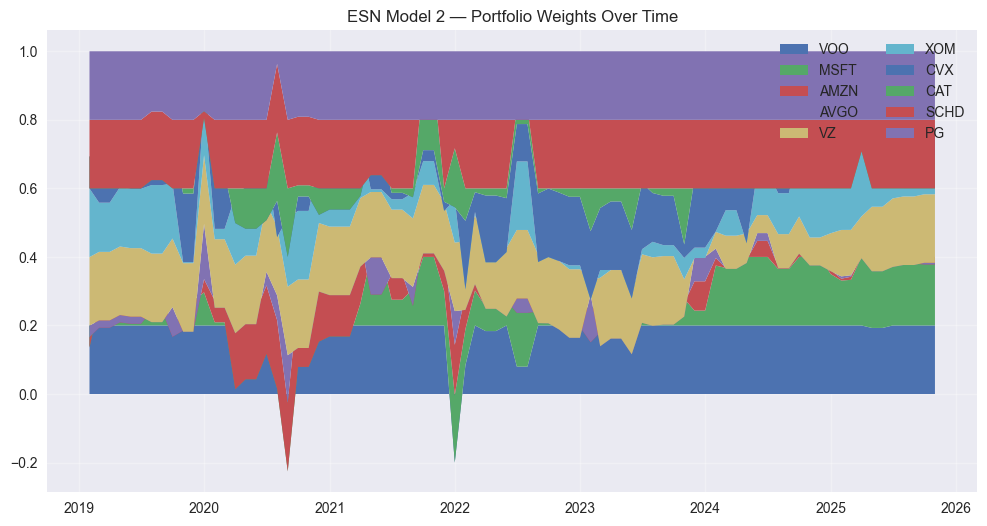

In [ ]:
# ============================================================
# 10. WEIGHTS OVER TIME (ESN portfolio)
# ============================================================

weights_esn = pd.DataFrame(results_esn2["weights"].tolist(),index=results_esn2.index)
weights_esn = weights_esn.reindex(portfolio_esn_monthly.index).ffill()

plt.figure(figsize=(12,6))
plt.stackplot(weights_esn.index,weights_esn.T,labels=weights_esn.columns)
plt.legend(loc="upper right", ncol=2)
plt.title("ESN (Model 2) Portfolio Weights Over Time")
plt.grid(alpha=0.3)
plt.show()

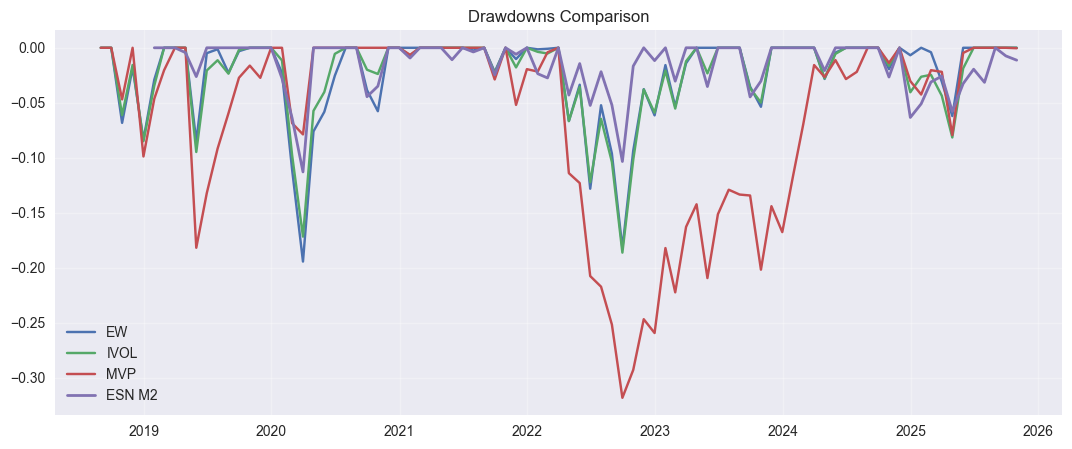

In [14]:
# ============================================================
# X3. Drawdowns Comparison
# ============================================================

def dd_curve(eq):
    return eq / eq.cummax() - 1

plt.figure(figsize=(13,5))
plt.plot(dd_curve(eq_EW),   label="EW")
plt.plot(dd_curve(eq_IVOL), label="IVOL")
plt.plot(dd_curve(eq_MVP),  label="MVP")
plt.plot(dd_curve(portfolio_esn_monthly), label="ESN M2", linewidth=2.0)

plt.grid(alpha=0.3)
plt.title("Drawdowns Comparison")
plt.legend()
plt.show()

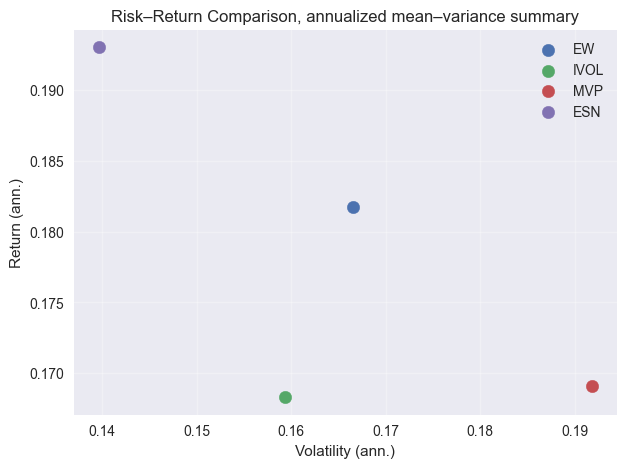

In [18]:
# ============================================================
# X4. Risk–Return Scatter
# ============================================================

rets = {
    "EW":   eq_EW.pct_change().dropna(),
    "IVOL": eq_IVOL.pct_change().dropna(),
    "MVP":  eq_MVP.pct_change().dropna(),
    "ESN":  r_esn_monthly
}

plt.figure(figsize=(7,5))
for k,v in rets.items():
    plt.scatter(v.std()*np.sqrt(12), v.mean()*12, s=80, label=k)

plt.grid(alpha=0.3)
plt.xlabel("Volatility (ann.)")
plt.ylabel("Return (ann.)")
plt.title("Risk–Return Comparison, annualized mean–variance summary")
plt.legend()
plt.show()


In [15]:
# ---------------- SAVE: EQUITY CURVES ----------------
df_eq = pd.concat([
    portfolio_esn_monthly.rename("ESN_Model2"),
    eq_EW.rename("EW"),
    eq_IVOL.rename("IVOL"),
    eq_MVP.rename("MVP")
], axis=1)

df_eq.to_csv(r"E:\data\Model2_data\equity_curves_monthly.csv", index_label="date")
df_eq

,ESN_Model2,EW,IVOL,MVP
2018-08-31,NaN,1.022298,1.029402,1.044997
2018-09-30,NaN,1.057340,1.057416,1.081762
2018-10-31,NaN,0.985129,0.992650,1.030988
2018-11-30,NaN,1.038227,1.040884,1.096703
2018-12-31,NaN,0.968780,0.967565,0.988280
...,...,...,...,...
2025-06-30,3.638472,3.125413,2.944709,2.893980
2025-07-31,3.594108,3.253611,3.021108,2.956056
2025-08-31,3.719325,3.304119,3.090866,3.033362
2025-09-30,3.691802,3.363319,3.114495,3.058891


In [16]:
# ---------------- SAVE: RETURNS ----------------
df_ret = pd.concat([
    r_ESN.rename("ESN_Model2"),
    r_EW.rename("EW"),
    r_IVOL.rename("IVOL"),
    r_MVP.rename("MVP")
], axis=1)

df_ret.to_csv(r"E:\data\Model2_data\returns_monthly.csv", index_label="date")
df_ret

,ESN_Model2,EW,IVOL,MVP
2018-09-30,NaN,0.034277,0.027214,0.035182
2018-10-31,NaN,-0.068295,-0.061249,-0.046937
2018-11-30,NaN,0.053899,0.048591,0.063740
2018-12-31,NaN,-0.066889,-0.070439,-0.098862
2019-01-31,NaN,0.059764,0.055299,0.058272
...,...,...,...,...
2025-06-30,0.013579,0.050508,0.034424,0.027462
2025-07-31,-0.012193,0.041018,0.025944,0.021450
2025-08-31,0.034839,0.015524,0.023090,0.026152
2025-09-30,-0.007400,0.017917,0.007645,0.008416


In [17]:
# ---------------- SAVE: DRAWDOWNS ----------------
dd_df = pd.concat([
    dd_curve(portfolio_esn_monthly).rename("ESN_Model2"),
    dd_curve(eq_EW).rename("EW"),
    dd_curve(eq_IVOL).rename("IVOL"),
    dd_curve(eq_MVP).rename("MVP")
], axis=1)

dd_df.to_csv(r"E:\data\Model2_data\drawdowns_monthly.csv", index_label="date")
dd_df

,ESN_Model2,EW,IVOL,MVP
2018-08-31,NaN,0.000000,0.000000,0.000000
2018-09-30,NaN,0.000000,0.000000,0.000000
2018-10-31,NaN,-0.068295,-0.061249,-0.046937
2018-11-30,NaN,-0.018077,-0.015634,0.000000
2018-12-31,NaN,-0.083757,-0.084972,-0.098862
...,...,...,...,...
2025-06-30,-0.019495,0.000000,0.000000,0.000000
2025-07-31,-0.031450,0.000000,0.000000,0.000000
2025-08-31,0.000000,0.000000,0.000000,0.000000
2025-09-30,-0.007400,0.000000,0.000000,0.000000


In [18]:
weights_esn.to_csv(r"E:\data\Model2_data\weights_esn_model2_monthly.csv", index_label="date")
weights_esn

,VOO,MSFT,AMZN,AVGO,VZ,XOM,CVX,CAT,SCHD,PG
date,,,,,,,,,,
2019-01-31,0.200000,-0.064150,0.030404,0.033335,0.200001,0.200000,0.093490,-0.093082,0.200001,0.200001
2019-02-28,0.200000,0.058365,-0.064851,0.021173,0.200000,0.143524,0.134767,-0.092978,0.200000,0.200000
2019-03-31,0.200000,0.058365,-0.064851,0.021173,0.200000,0.143524,0.134767,-0.092978,0.200000,0.200000
2019-04-30,0.200000,0.088425,-0.079471,0.021427,0.199999,0.173428,0.071249,-0.075055,0.200000,0.199999
2019-05-31,0.200000,0.088148,-0.083331,0.020808,0.200000,0.172844,0.077806,-0.076276,0.200000,0.200000
...,...,...,...,...,...,...,...,...,...,...
2025-06-30,0.199995,0.199994,-0.027045,-0.002234,0.199987,0.199998,-0.065122,-0.105552,0.199994,0.199986
2025-07-31,0.199997,0.199996,-0.019518,-0.004103,0.199991,0.199998,-0.071230,-0.105118,0.199996,0.199991
2025-08-31,0.199997,0.199996,-0.019518,-0.004103,0.199991,0.199998,-0.071230,-0.105118,0.199996,0.199991
